In [251]:
# importing basic libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import csv
from datetime import datetime
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [2]:
# reading train, test and val data

files = ["train.txt", "test.txt", "val.txt"]
di = {}

for file in files:
    name = file.split(".")[0]
    with open('../01. Data/' + file) as f:
        di[name] = json.load(f)

In [3]:
len(di["train"].keys()),len(di["val"].keys()),len(di["test"].keys())

(1111, 192, 192)

# 01. Putting everything in a dataframe for simplicity

In [8]:
# aspects
aspects_li = []
errors_li = []
for key in di["train"].keys():
    try:
        aspects_li.append(re.findall(r"'(.*?)'", di["train"][key]["info"][0]["aspects"], re.DOTALL)[0])
    except:
        errors_li.append(key)
        
print("total items processed: {}".format(len(aspects_li)))
print("total errors: {}".format(len(errors_li)))
print("samples: {}".format(aspects_li[0:5]))

total items processed: 1111
total errors: 0
samples: ['Corporate/Appointment', 'Market/Volatility/Volatility', 'Corporate/Regulatory', 'Corporate/Strategy', 'Corporate/Strategy']


In [9]:
# sentiment_score
sentiments_li = []
errors2_li = []
for key in di["train"].keys():
    try:
        sentiments_li.append(float(di["train"][key]["info"][0]["sentiment_score"]))
    except:
        errors2_li.append(key)
        
print("total items processed: {}".format(len(sentiments_li)))
print("total errors: {}".format(len(errors2_li)))
print("samples: {}".format(sentiments_li[0:5]))

total items processed: 1111
total errors: 0
samples: [-0.374, -0.827, 0.549, -0.266, -0.461]


In [25]:
# snippets
snippets_li = []
errors3_li = []
for key in di["train"].keys():
    try:
        my_str = re.sub('[^a-zA-Z0-9 \n\.]', '', di["train"][key]["info"][0]["snippets"])
        snippets_li.append(my_str)
    except:
        errors3_li.append(key)
        
print("total items processed: {}".format(len(snippets_li)))
print("total errors: {}".format(len(errors3_li)))
print("samples: {}".format(snippets_li[0:5]))

total items processed: 1111
total errors: 0
samples: ['set to step down', 'down from record high', 'FDA approval for key new lung cancer pill', 'cut 945 jobs as part of 3year restructuring plan', 'Shifts EmergingMarkets Strategy']


In [27]:
# target
target_li = []
errors4_li = []
for key in di["train"].keys():
    try:
        my_str = re.sub('[^a-zA-Z0-9 \n\.]', '', di["train"][key]["info"][0]["target"])
        target_li.append(my_str)
    except:
        errors4_li.append(key)
        
print("total items processed: {}".format(len(target_li)))
print("total errors: {}".format(len(errors4_li)))
print("samples: {}".format(target_li[0:5]))

total items processed: 1111
total errors: 0
samples: ['Royal Mail', 'Weir', 'AstraZeneca', 'Lloyds', 'Standard Chartered']


In [31]:
# sentence
sentence_li = []
errors5_li = []
for key in di["train"].keys():
    try:
        my_str = di["train"][key]["sentence"]
        sentence_li.append(my_str)
    except:
        errors5_li.append(key)
        
print("total items processed: {}".format(len(sentence_li)))
print("total errors: {}".format(len(errors5_li)))
print("samples: {}".format(sentence_li[0:5]))

total items processed: 1111
total errors: 0
samples: ['Royal Mail chairman Donald Brydon set to step down', 'Slump in Weir leads FTSE down from record high', 'AstraZeneca wins FDA approval for key new lung cancer pill', 'UPDATE 1-Lloyds to cut 945 jobs as part of 3-year restructuring plan', 'Standard Chartered Shifts Emerging-Markets Strategy After Losses']


In [34]:
# putting everything in a dataframe
df = pd.DataFrame({"aspects":aspects_li, 
                      "sentiments":sentiments_li, 
                      "snippets":snippets_li, 
                      "target":target_li, 
                      "sentence":sentence_li})
df.shape

(1111, 5)

In [40]:
df.head(5)

,aspects,sentiments,snippets,target,sentence
0,Corporate/Appointment,-0.374,set to step down,Royal Mail,Royal Mail chairman Donald Brydon set to step ...
1,Market/Volatility/Volatility,-0.827,down from record high,Weir,Slump in Weir leads FTSE down from record high
2,Corporate/Regulatory,0.549,FDA approval for key new lung cancer pill,AstraZeneca,AstraZeneca wins FDA approval for key new lung...
3,Corporate/Strategy,-0.266,cut 945 jobs as part of 3year restructuring plan,Lloyds,UPDATE 1-Lloyds to cut 945 jobs as part of 3-y...
4,Corporate/Strategy,-0.461,Shifts EmergingMarkets Strategy,Standard Chartered,Standard Chartered Shifts Emerging-Markets Str...


In [39]:
# saving to csv for future use
df.to_csv("../01. Data/train.csv", index=False, index_label=False)

# 02. EDA

#### *credits to: stackoverflow tag predictor problem in our course case studies*

## 02.1 Distribution of aspects

In [121]:
vectorizer = CountVectorizer()
aspects_dtm = vectorizer.fit_transform(df.aspects)

In [122]:
print("Number of data points :", aspects_dtm.shape[0])
print("Number of unique aspects :", aspects_dtm.shape[1])

Number of data points : 1111
Number of unique aspects : 143


In [123]:
#'get_feature_name()' gives us the vocabulary.
aspects = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the aspects we have :", aspects[:10])

Some of the aspects we have : ['52', 'accounting', 'action', 'activity', 'agreement', 'analysis', 'analystratings', 'appointment', 'bankruptcy', 'banks']


## 02.2 Number of times aspect appeared

In [124]:
#Lets now store the document term matrix in a dictionary.
freqs = aspects_dtm.sum(axis=0).A1
result = dict(zip(aspects, freqs))

In [140]:
#Saving this dictionary to csv files.
if not os.path.isfile('../01. Data/aspect_counts_dict_dtm.csv'):
    with open('aspect_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
aspects_df = pd.read_csv("aspect_counts_dict_dtm.csv", names=['aspects', 'Counts'])
aspects_df.head(2)

,aspects,Counts
0,52,4
1,accounting,3


In [141]:
aspects_df_sorted = aspects_df.sort_values(['Counts'], ascending=False)
aspects_counts = aspects_df_sorted['Counts'].values

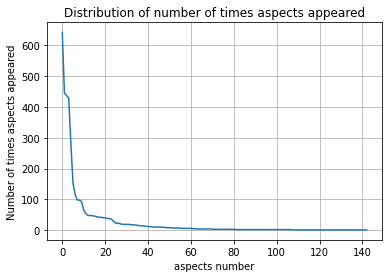

In [142]:
plt.plot(aspects_counts)
plt.title("Distribution of number of times aspects appeared")
plt.grid()
plt.xlabel("aspects number")
plt.ylabel("Number of times aspects appeared")
plt.show()

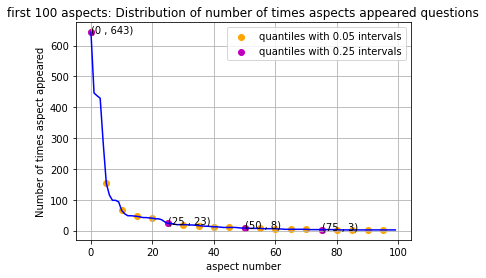

20 [643 153  65  46  40  23  19  16  12  10   8   7   6   4   4   3   3   2
   2   2]


In [143]:
plt.plot(aspects_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=aspects_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=aspects_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), aspects_counts[0:100:25]):
    plt.annotate(text="({} , {})".format(x,y), xy=(x,y))

plt.title('first 100 aspects: Distribution of number of times aspects appeared questions')
plt.grid()
plt.xlabel("aspect number")
plt.ylabel("Number of times aspect appeared")
plt.legend()
plt.show()
print(len(aspects_counts[0:100:5]), aspects_counts[0:100:5])

In [145]:
# Store aspects greater than 2 in one list
lst_aspects_gt_2 = aspects_df[aspects_df.Counts>2].aspects
#Print the length of the list
print ('{} aspects are used more than 2 times'.format(len(lst_aspects_gt_2)))
# Store aspects greater than 50 in one list
lst_aspects_gt_50 = aspects_df[aspects_df.Counts>50].aspects
#Print the length of the list.
print ('{} aspects are used more than 50 times'.format(len(lst_aspects_gt_50)))

81 aspects are used more than 2 times
12 aspects are used more than 50 times


### observations:
1. There are 81 aspects used more than 2 times
2. 12 aspects are used more than 50 times
3. Stock is the most used aspect and is used 643 times
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

## 02.3 Aspects per item

In [148]:
#Storing the count of aspects in each question in list 'aspects_count'
aspects_quest_count = aspects_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
aspects_quest_count=[int(j) for i in aspects_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(aspects_quest_count)))

print(aspects_quest_count[:5])

We have total 1111 datapoints.
[2, 3, 2, 2, 2]


In [150]:
print( "Maximum number of aspects per question: %d"%max(aspects_quest_count))
print( "Minimum number of aspects per question: %d"%min(aspects_quest_count))
print( "Avg. number of aspects per question: %f"% ((sum(aspects_quest_count)*1.0)/len(aspects_quest_count)))

Maximum number of aspects per question: 8
Minimum number of aspects per question: 1
Avg. number of aspects per question: 3.649865


C:\anaconda\envs\generics\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


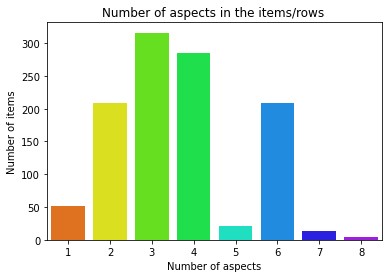

In [155]:
sns.countplot(aspects_quest_count, palette='gist_rainbow')
plt.title("Number of aspects in the items/rows ")
plt.xlabel("Number of aspects")
plt.ylabel("Number of items")
plt.show()

### observations:
1. Maximum number of aspects per question: 8
2. Minimum number of aspects per question: 1
3. Avg. number of aspects per question: 3.649865
4. As per the above countplot most number of rows/datapoints have either 3 or 4 aspects

## 02.4 Most frequent aspects 

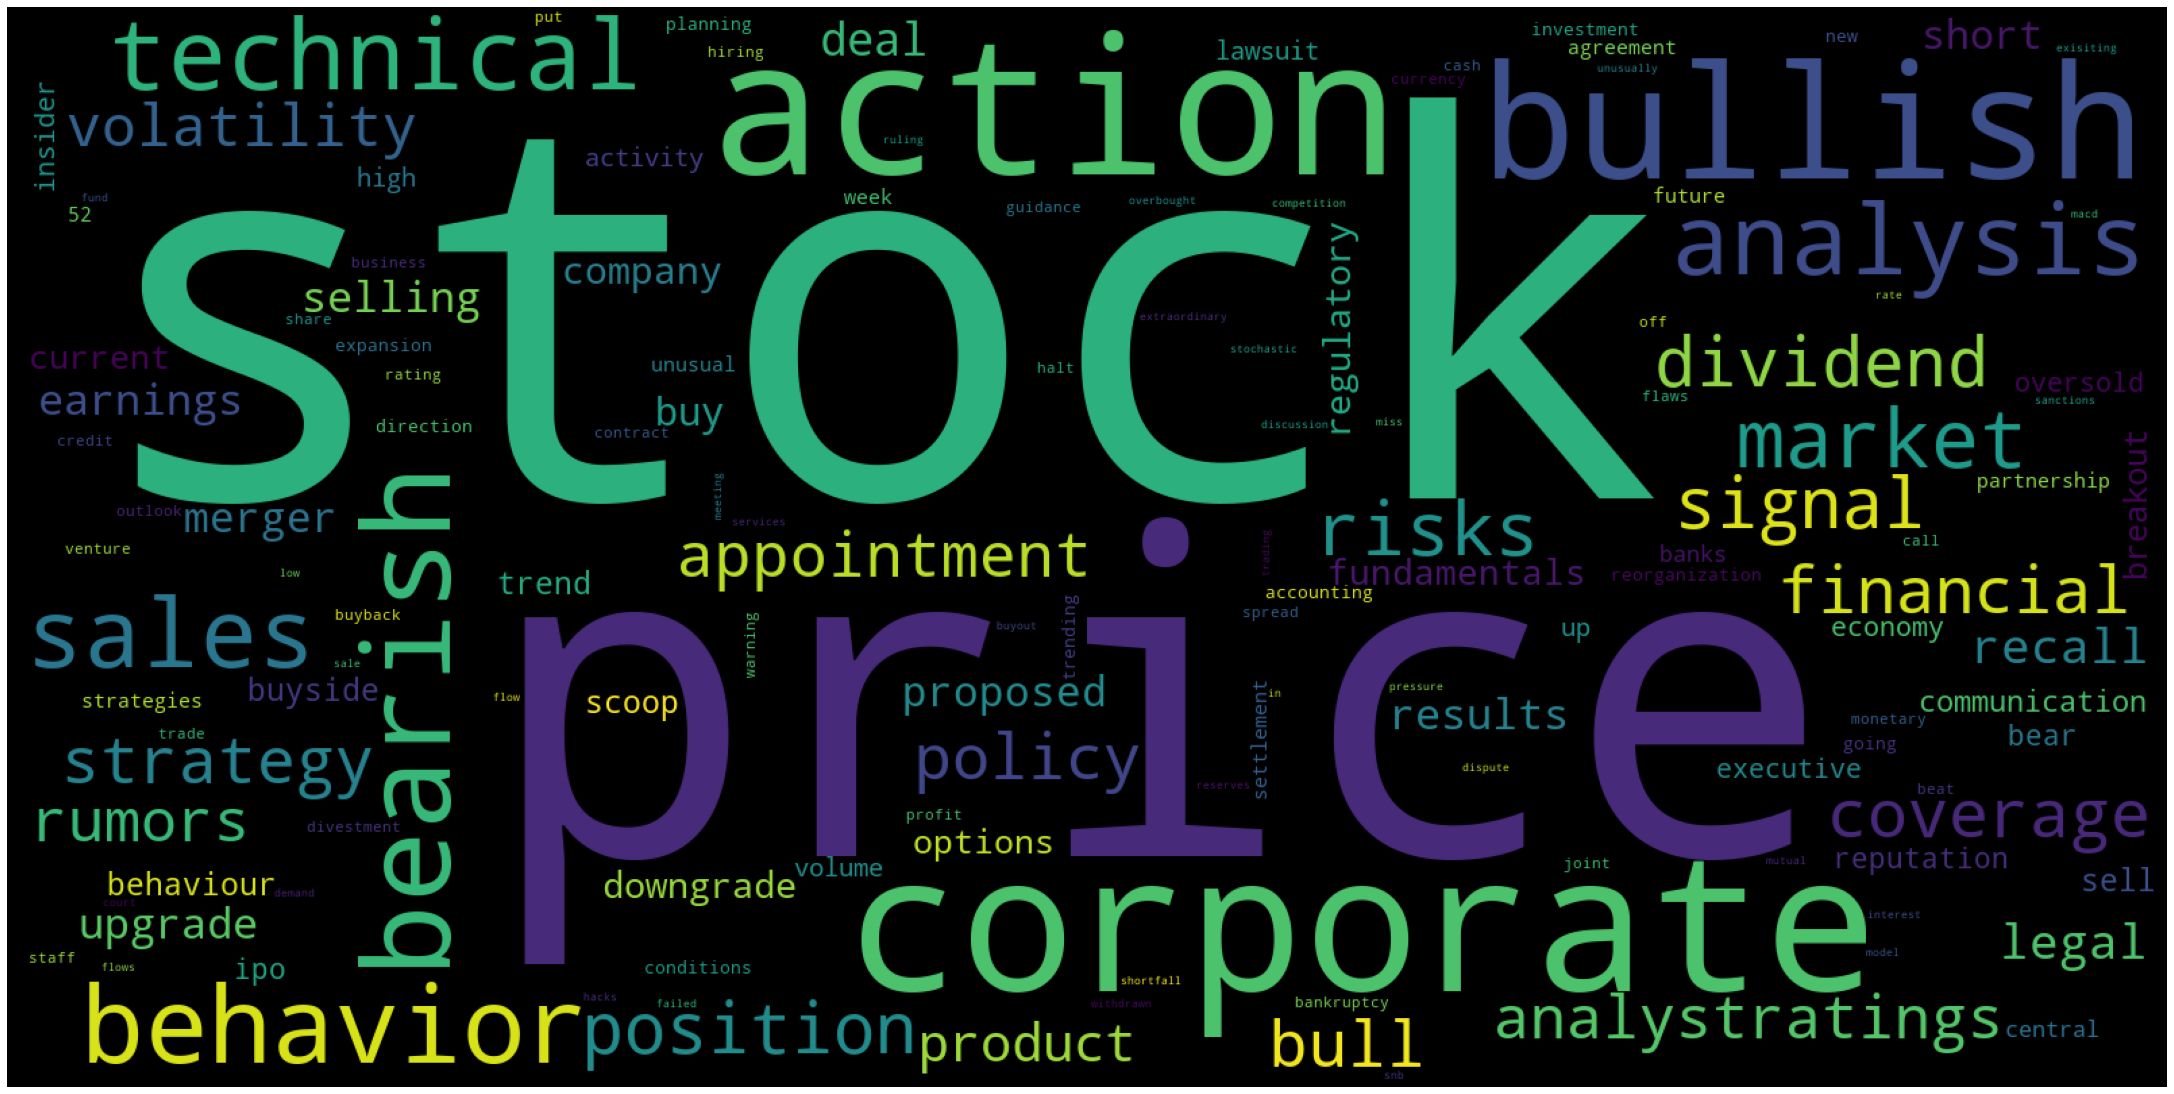

Time taken to run this cell : 0:00:02.400179


In [165]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
# fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

### observations:
1. stock, price, corporate, action, bullish seem to be the major aspects with a lot of datapoints

<h2> 02.5 The top 20 aspects </h2>

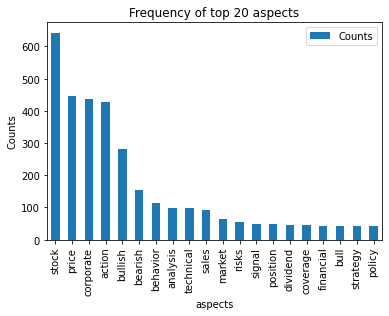

In [174]:
i=np.arange(20)
aspects_df_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 aspects')
plt.xticks(i, aspects_df_sorted['aspects'][:20])
plt.xlabel('aspects')
plt.ylabel('Counts')
plt.show()

## 02.6 checking for null and duplicate values

In [166]:
df.isnull().sum()

aspects       0
sentiments    0
snippets      0
target        0
sentence      0
dtype: int64

In [167]:
df[df.duplicated()]

,aspects,sentiments,snippets,target,sentence


### observations
    1. No nulls or duplicates found

## 02.7 Lets look at sentiments

C:\anaconda\envs\generics\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sentiments', ylabel='Density'>

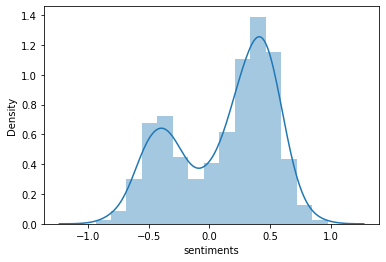

In [176]:
sns.distplot(df.sentiments)

In [185]:
# general metrics
print("max sentiment: {} | min sentiment: {} | average sentiment: {}".format(np.max(df.sentiments), np.min(df.sentiments), np.mean(df.sentiments)))

max sentiment: 0.975 | min sentiment: -0.938 | average sentiment: 0.12258145814581457


In [190]:
# lets bucket the sentiments to +ve, -ve and neutral
sentiments_bucket = []
error_bucket = []
for elem in np.array(df.sentiments):
    try:
        if elem > 0:
            sentiments_bucket.append("positive")
        elif elem < 0:
            sentiments_bucket.append("negative")
        else:
            sentiments_bucket.append("neutral")
    except:
        error_bucket.append(elem)
print(len(sentiments_bucket), len(error_bucket))
print("sample: ", sentiments_bucket[0:5])

1111 0
sample:  ['negative', 'negative', 'positive', 'negative', 'negative']


C:\anaconda\envs\generics\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


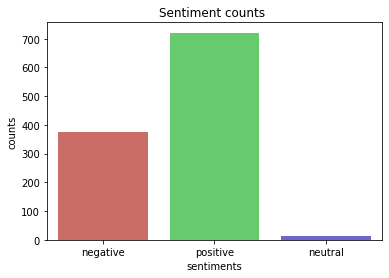

In [218]:
# lets get the counts for these
sns.countplot(sentiments_bucket, palette='hls')
plt.title("Sentiment counts ")
plt.xlabel("sentiments")
plt.ylabel("counts")
plt.show()

C:\anaconda\envs\generics\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


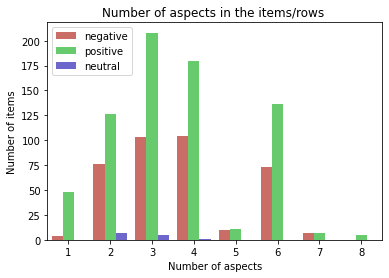

In [219]:
sns.countplot(aspects_quest_count, palette='hls', hue=sentiments_bucket)
plt.title("Number of aspects in the items/rows ")
plt.xlabel("Number of aspects")
plt.ylabel("Number of items")
plt.show()

### observations:
1. most of the rows are +ve, followed by -ve and barely any neutrals
2. The distribution of aspect frequency is same across all sentiments

## 02.8 Target column

In [246]:
vectorizer = CountVectorizer()
target_dtm = vectorizer.fit_transform(df.target)

print("Number of data points :", target_dtm.shape[0])
print("Number of unique target :", target_dtm.shape[1])

#'get_feature_name()' gives us the vocabulary.
target = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the target we have :", target[:10])

#Lets now store the document term matrix in a dictionary.
freqs = target_dtm.sum(axis=0).A1
result = dict(zip(target, freqs))

#Saving this dictionary to csv files.
if not os.path.isfile('../01. Data/target_counts_dict_dtm.csv'):
    with open('target_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
target_df = pd.read_csv("target_counts_dict_dtm.csv", names=['target', 'Counts'])

Number of data points : 1111
Number of unique target : 539
Some of the target we have : ['aal', 'aapl', 'ab', 'aberdeen', 'acad', 'ace', 'acom', 'actelion', 'adbe', 'aegn']


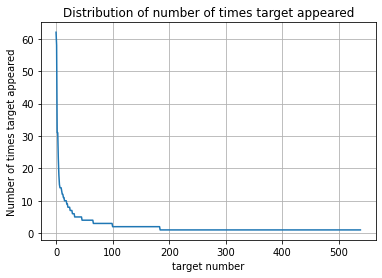

In [247]:
target_df_sorted = target_df.sort_values(['Counts'], ascending=False)
target_counts = target_df_sorted['Counts'].values

plt.plot(target_counts)
plt.title("Distribution of number of times target appeared")
plt.grid()
plt.xlabel("target number")
plt.ylabel("Number of times target appeared")
plt.show()

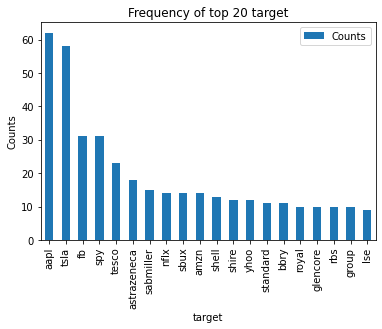

In [249]:
i=np.arange(20)
target_df_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 target')
plt.xticks(i, target_df_sorted['target'][:20])
plt.xlabel('target')
plt.ylabel('Counts')
plt.show()

### observations:
1. Targets column here represent the companies that the article/statement is related to
2. There are repeating targets and the top ones are aapl, tsla, fb, etc..

## 02.9 snippet & sentence column

In [250]:
# we combine these 2 columns, clean them and then look at the top frequent words
df["combined"] = df.snippets + " " + df.sentence
text_li = list(df.combined)
print(len(text_li), text_li[0:3])

1111 ['set to step down Royal Mail chairman Donald Brydon set to step down', 'down from record high Slump in Weir leads FTSE down from record high', 'FDA approval for key new lung cancer pill AstraZeneca wins FDA approval for key new lung cancer pill']


In [278]:
'''
basic preprocessing steps:
01. remove numbers
02. lower case
03. remove \'
''' 

def preprocess(text):
    # lower case
    text = text.lower()
    # remove \'
    text = re.sub('[^a-zA-Z0-9 \n\.]', '',text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove punctuations
    text = re.sub(r'[^\w\s]','', text)
    # remove leading and trailing spaces
    text = text.strip()
    # remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    text = pattern.sub('', text)
    return text

news_li = []
news_error = []
for elem in text_li:
    try:
        news_li.append(preprocess(elem))
    except:
        news_error.append(elem)
        
print("sentences processed: {}, sentences failed: {}".format(len(news_li), len(news_error)))

sentences processed: 1111, sentences failed: 0


In [279]:
vectorizer = CountVectorizer()
news_dtm = vectorizer.fit_transform(news_li)

print("Number of data points :", news_dtm.shape[0])
print("Number of unique news :", news_dtm.shape[1])

#'get_feature_name()' gives us the vocabulary.
news = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the news we have :", news[:10])

#Lets now store the document term matrix in a dictionary.
freqs = news_dtm.sum(axis=0).A1
result = dict(zip(news, freqs))

#Saving this dictionary to csv files.
if not os.path.isfile('../01. Data/news_counts_dict_dtm.csv'):
    with open('news_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
news_df = pd.read_csv("news_counts_dict_dtm.csv", names=['news', 'Counts'])

Number of data points : 1111
Number of unique news : 3752
Some of the news we have : ['aa', 'aal', 'aapl', 'ab', 'abandons', 'abbv', 'abc', 'aberdeen', 'abov', 'acad']


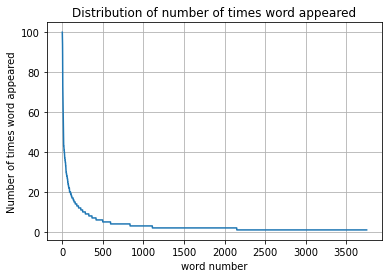

In [283]:
news_df_sorted = news_df.sort_values(['Counts'], ascending=False)
news_counts = news_df_sorted['Counts'].values

plt.plot(news_counts)
plt.title("Distribution of number of times word appeared")
plt.grid()
plt.xlabel("word number")
plt.ylabel("Number of times word appeared")
plt.show()

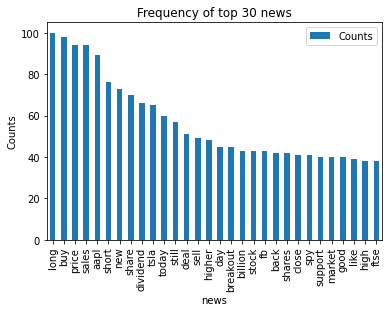

In [297]:
i=np.arange(30)
news_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 30 news')
plt.xticks(i, news_df_sorted['news'][:30])
plt.xlabel('news')
plt.ylabel('Counts')
plt.show()

In [300]:
df["news"] = news_li

In [302]:
# saving to csv for future use
df.to_csv("../01. Data/train_final.csv", index=False, index_label=False)